# Telco Customer Churn Prediction

## Task 1: Exploratory Data Analysis (EDA)
This notebook covers the step-by-step process of analyzing the Telco Customer Churn dataset, preprocessing the data, building classification models, and evaluating them.

### 1.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Set visualization style
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 1.2 Load Dataset

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1.3 Data Cleaning & Inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# 'TotalCharges' is object but should be numeric. Coerce errors to NaN.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [5]:
# Drop rows with missing TotalCharges (usually very few)
df.dropna(inplace=True)

# Remove 'customerID' as it's not a feature
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

print("New Shape after cleaning:", df.shape)

New Shape after cleaning: (7032, 20)


In [6]:
# SAVE CLEANED DATASET
df.to_csv("cleaned_telco_churn.csv", index=False)
print("Cleaned dataset saved as 'cleaned_telco_churn.csv'")


Cleaned dataset saved as 'cleaned_telco_churn.csv'


### 1.4 Visualization

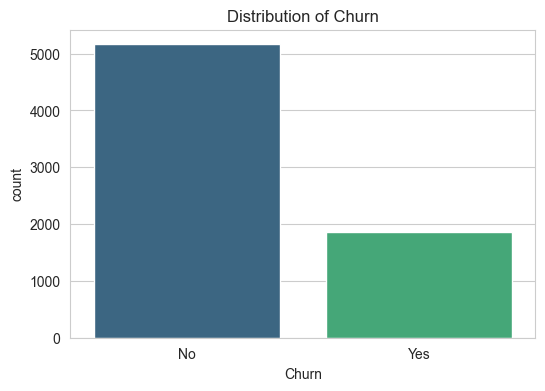

In [7]:
# Target Variable Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Distribution of Churn')
plt.show()

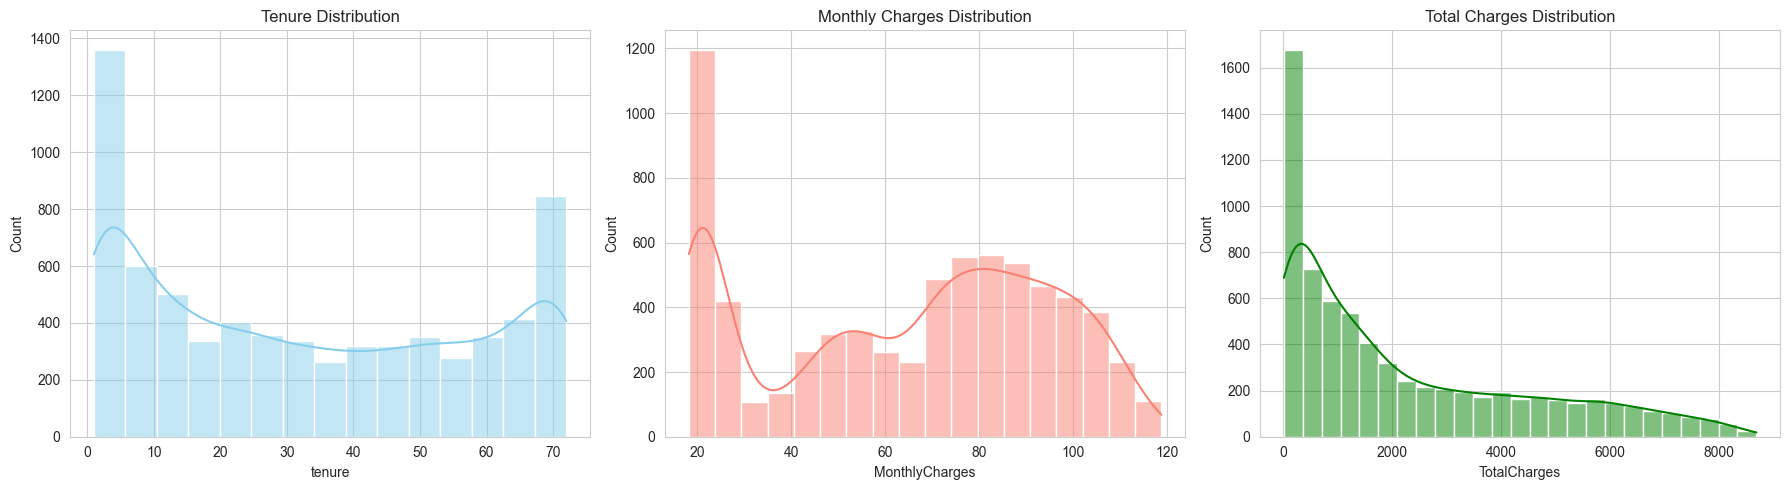

In [8]:
# Numerical Features Distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['tenure'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Tenure Distribution')

sns.histplot(df['MonthlyCharges'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Monthly Charges Distribution')

sns.histplot(df['TotalCharges'], kde=True, ax=axes[2], color='green')
axes[2].set_title('Total Charges Distribution')

plt.tight_layout()
plt.show()

In [9]:
# Standardizing column names to lowercase for ease
df.columns = [c.lower() for c in df.columns]
print(df.columns)

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod',
       'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')


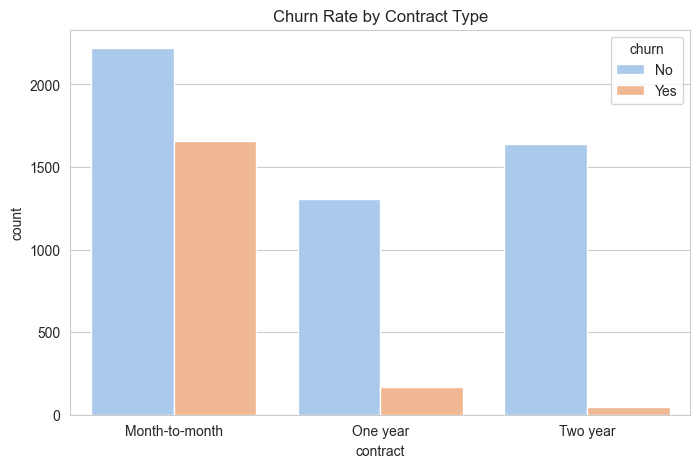

In [10]:
# Churn vs Contract Type
plt.figure(figsize=(8,5))
sns.countplot(x='contract', hue='churn', data=df, palette='pastel')
plt.title('Churn Rate by Contract Type')
plt.show()

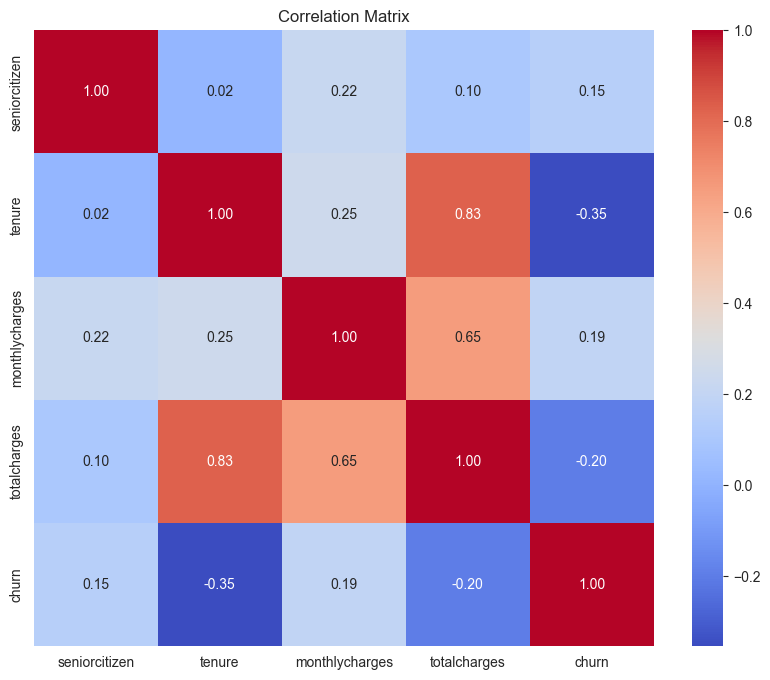

In [11]:
# Correlation Matrix
df_corr = df.copy()
df_corr['churn'] = df_corr['churn'].apply(lambda x: 1 if x == 'Yes' else 0)
numeric_df = df_corr.select_dtypes(include=['number'])

plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Task 2: Model Implementation

### 2.1 Data Preprocessing
- Encoding Categorical Variables
- Feature Scaling
- Train-Test Split

In [19]:
# 1. Drop Target from features
X = df.drop('churn', axis=1)
y = df['churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# 2. Encoding Categorical Variables
# Get dummy variables for categorical features, drop_first to avoid multicollinearity
X = pd.get_dummies(X, drop_first=True)

# 3. Scaling Numerical Features
# Identify numerical cols: tenure, monthlycharges, totalcharges
num_cols = ['tenure', 'monthlycharges', 'totalcharges']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")
X.head()

Training Shape: (5625, 30)
Testing Shape: (1407, 30)


,seniorcitizen,tenure,monthlycharges,totalcharges,gender_Male,partner_Yes,dependents_Yes,phoneservice_Yes,multiplelines_No phone service,multiplelines_Yes,...,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No internet service,streamingmovies_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,0,-1.280248,-1.161694,-0.994194,False,True,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
1,0,0.064303,-0.260878,-0.173740,True,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,True
2,0,-1.239504,-0.363923,-0.959649,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
3,0,0.512486,-0.747850,-0.195248,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
4,0,-1.239504,0.196178,-0.940457,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False


### 2.2 Decision Tree Classifier
- Implementation
- Hyperparameter Tuning (GridSearchCV)

In [13]:
# Init Model
dt = DecisionTreeClassifier(random_state=42)

# Hyperparameter Grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Grid Search
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
print("Parameters which are best suited for the Decision Tree:", grid_search.best_params_)

# Predictions
y_pred_dt = best_dt.predict(X_test)

# Evaluation
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

Parameters which are best suited for the Decision Tree: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Decision Tree Accuracy: 0.7846481876332623

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86      1033
           1       0.66      0.40      0.50       374

    accuracy                           0.78      1407
   macro avg       0.73      0.66      0.68      1407
weighted avg       0.77      0.78      0.77      1407



### 2.3 Neural Network Classifier
- Implementation using TensorFlow/Keras
- Model Architecture: Input -> Dense(ReLU) -> Dropout -> Dense(ReLU) -> Output(Sigmoid)

In [14]:
model = Sequential()

# Input Layer & 1st Hidden Layer
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.1))

# 2nd Hidden Layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.7546 - loss: 0.4993 - val_accuracy: 0.7940 - val_loss: 0.4219
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7930 - loss: 0.4383 - val_accuracy: 0.8064 - val_loss: 0.3996
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7993 - loss: 0.4302 - val_accuracy: 0.8064 - val_loss: 0.3963
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7955 - loss: 0.4280 - val_accuracy: 0.8082 - val_loss: 0.3934
Epoch 5/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8007 - loss: 0.4226 - val_accuracy: 0.8082 - val_loss: 0.3929
Epoch 6/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7999 - loss: 0.4225 - val_accuracy: 0.8028 - val_loss: 0.3988
Epoch 7/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8019 - loss: 0.4195 - val_accuracy: 0.8117 - val_loss: 0.3952
Epoch 8/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8050 - loss: 0.4173 - val_acc

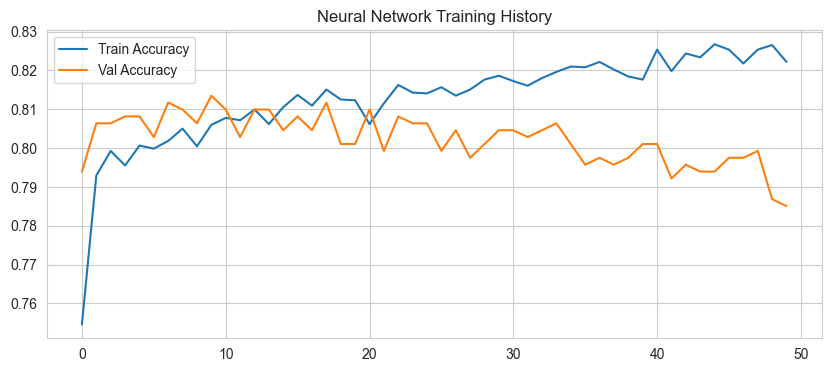

In [15]:
# Plot Training History
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Neural Network Training History')
plt.legend()
plt.show()

In [16]:
# Evaluation
y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_nn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nn))

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Neural Network Accuracy: 0.7853589196872779

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86      1033
           1       0.61      0.55      0.58       374

    accuracy                           0.79      1407
   macro avg       0.72      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407



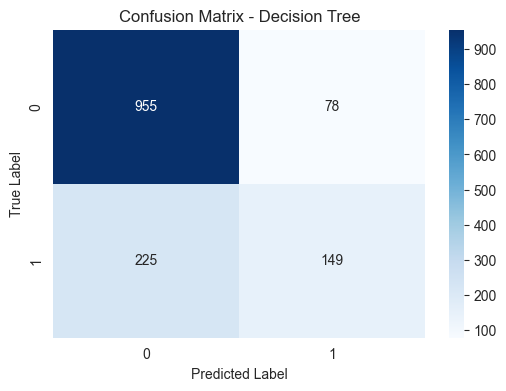

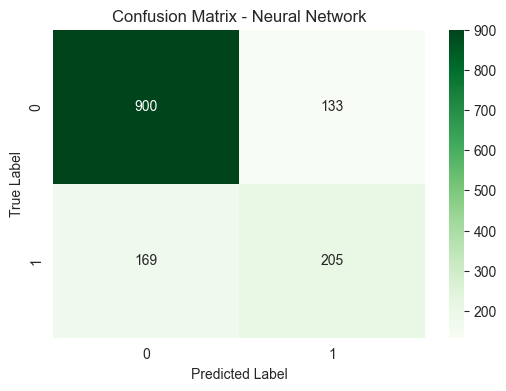

In [20]:
# CONFUSION MATRIX - DECISION TREE
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6,4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# CONFUSION MATRIX - NEURAL NETWORK
cm_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(6,4))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Neural Network")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### 2.4 Model Comparison (ROC-AUC)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


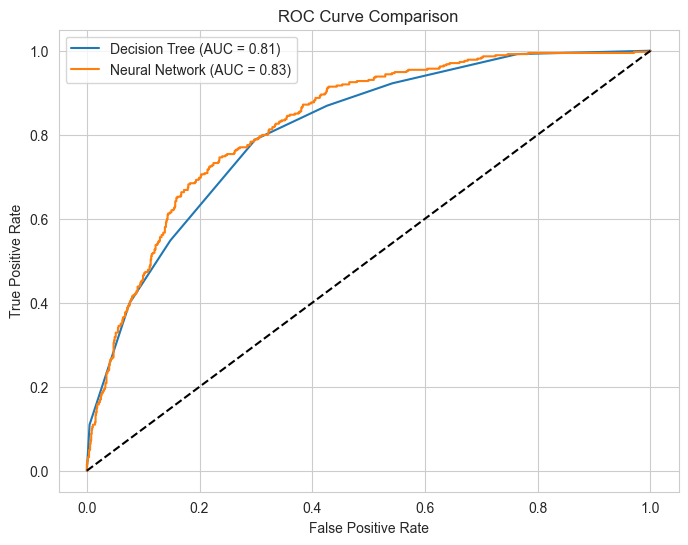

In [17]:
# Decision Tree Probabilities
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
auc_dt = auc(fpr_dt, tpr_dt)

# Neural Network Probabilities
y_prob_nn = model.predict(X_test).ravel()
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)
auc_nn = auc(fpr_nn, tpr_nn)

plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()